<b>Anomaly Detection</b><br>

Anomaly Detection is used to determine where outliers lay in a dataset. The challenge is to seperate out the outliers from noise and the normal data. It is frequently used in fraud detection, anti money laundering and security applications. There are areas where there will be a class imbalance in occurences of actual fraud or actual security breaches.<br>

it can be difficult to label data in some cases (where we suspect something has happend but do not have ground truth). We can use some anomaly detection algorithms which are **unsupervised**, meaning there is no target. there are also some **supervised** methods if we have labeled data to train with.

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

sns.set(style='darkgrid')

#zips are automatically opened, 2 directories deep probably part of unzip process
print(os.listdir("../input/realTweets/realTweets/"))
df_amz = pd.read_csv('../input/realTweets/realTweets/Twitter_volume_AMZN.csv')


['Twitter_volume_CVS.csv', 'Twitter_volume_IBM.csv', 'Twitter_volume_PFE.csv', 'Twitter_volume_AMZN.csv', 'Twitter_volume_CRM.csv', 'Twitter_volume_UPS.csv', 'Twitter_volume_AAPL.csv', 'Twitter_volume_FB.csv', 'Twitter_volume_KO.csv', 'Twitter_volume_GOOG.csv']


In [2]:
#dfs are datestamp,value (number of times in 5 minute periods of how often the company is mentioned)
print(df_amz.shape)

(15831, 2) (15893, 2)


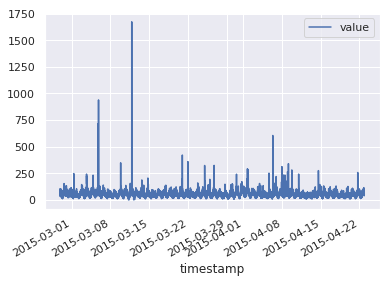

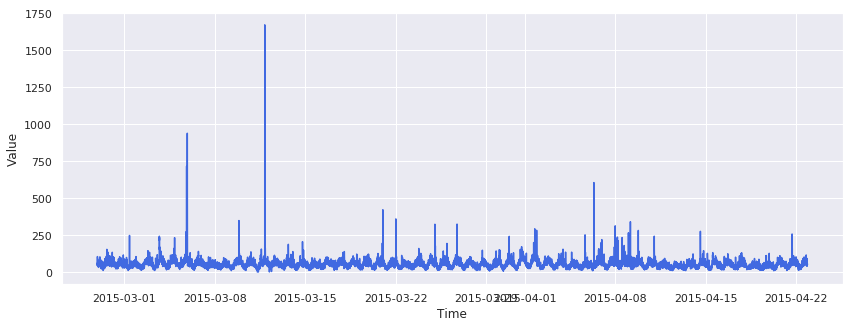

In [3]:
#using the built in df.plot works nicely since it automatically fits the x labels
df_amz['timestamp'] = pd.to_datetime(df_amz['timestamp'])
df_amz.plot(x='timestamp',y='value')
plt.show()

#alternatively, use seaborn to make a big, clear graph
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(df_amz['timestamp'], df_amz['value'], color='royalblue')
plt.ylabel("Value")
plt.xlabel("Time")
plt.show()

In [4]:
#feature engineering
df_amz['hours'] = df_amz['timestamp'].dt.hour
df_amz['daylight'] = ((df_amz['hours'] >= 7) & (df_amz['hours'] <= 20)).astype(int)
df_amz['DayOfTheWeek'] = df_amz['timestamp'].dt.dayofweek
df_amz['WeekDay'] = (df_amz['DayOfTheWeek'] < 5).astype(int)

#estimate of percentage of outliers in each dataframe
outliers_fraction = 0.01

In [7]:
df_amz['time_epoch'] = (df_amz['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [8]:
#make categories based on if it is a weekday or not and if it is night time or not
df_amz['categories'] = df_amz['WeekDay']*2 + df_amz['daylight']

a = df_amz.loc[df_amz['categories'] == 0, 'value']
b = df_amz.loc[df_amz['categories'] == 1, 'value']
c = df_amz.loc[df_amz['categories'] == 2, 'value']
d = df_amz.loc[df_amz['categories'] == 3, 'value']

<b>Methods of Anomaly Detection</b>

<b>Local Outlier Factor (LOF)</b>

Wikipedia:The local outlier factor is based on a concept of a local density, where locality is given by ${k}$, k nearest neighbors, whose distance is used to estimate the density. By comparing the local density of an object to the local densities of its neighbors, one can identify regions of similar density, and points that have a substantially lower density than their neighbors. These are considered to be outliers.

The local density is estimated by the typical distance at which a point can be "reached" from its neighbors. The definition of "reachability distance" used in LOF is an additional measure to produce more stable results within clusters.

0    15672
1      159
Name: anomaly1, dtype: int64


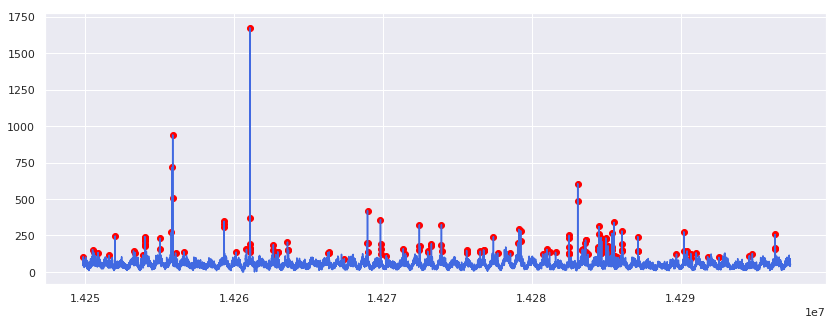

In [9]:
lof = LocalOutlierFactor(n_neighbors=30, contamination=outliers_fraction)

df_amz['anomaly1'] = pd.Series(lof.fit_predict(df_amz[['time_epoch','value']]))
df_amz['anomaly1'] = df_amz['anomaly1'].map( {1: 0, -1: 1} )
print(df_amz['anomaly1'].value_counts())

fig, ax = plt.subplots(figsize=(14,5))

anomaly = df_amz.loc[df_amz['anomaly1'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df_amz['time_epoch'], df_amz['value'], color='royalblue')
ax.scatter(anomaly['time_epoch'],anomaly['value'], color='red')
plt.show()

<b>One class SVM</b>

effectively a classifier which is only looking for one class and treats others as outliers. nu parameter is how much is taken from the final prediction. Still has performed poorly compared to the others, just based on the visualisations.

0    15676
1      155
Name: anomaly2, dtype: int64


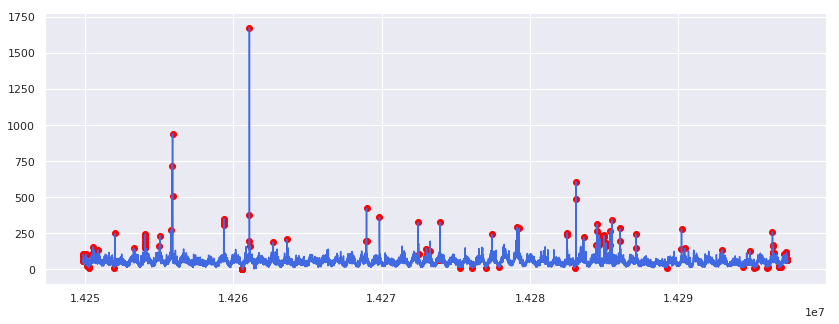

In [23]:
oc_svm = OneClassSVM(nu=0.01, kernel="rbf",gamma='scale')

min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(df_amz[['time_epoch','value']])
predictions = oc_svm.fit(np_scaled).predict(np_scaled)

df_amz['anomaly2'] = pd.Series(predictions)
df_amz['anomaly2'] = df_amz['anomaly2'].map( {1: 0, -1: 1} )
print(df_amz['anomaly2'].value_counts())

fig, ax = plt.subplots(figsize=(14,5))

anomaly = df_amz.loc[df_amz['anomaly2'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df_amz['time_epoch'], df_amz['value'], color='royalblue')
ax.scatter(anomaly['time_epoch'],anomaly['value'], color='red')
plt.show()

**Isolation Forest**

In [10]:
data = df_amz[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction, behaviour="new")
model.fit(data)

# add the data to the main  
df_amz['anomaly3'] = pd.Series(model.predict(data))
df_amz['anomaly3'] = df_amz['anomaly3'].map( {1: 0, -1: 1} )
print(df_amz['anomaly3'].value_counts())


0    15672
1      159
Name: anomaly3, dtype: int64


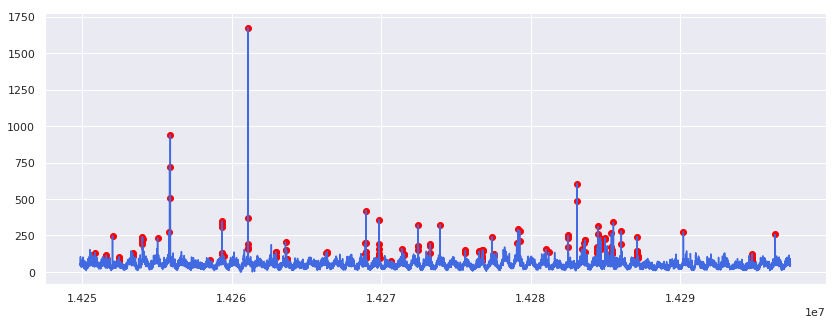

In [21]:
fig, ax = plt.subplots(figsize=(14,5))

a = df_amz.loc[df_amz['anomaly3'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df_amz['time_epoch'], df_amz['value'], color='royalblue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

<b>Other Methods</b>

**Density based method:**<br>
DBSCAN Clustering<br>
LOF (Local Outlier Factor)<br>
PCA (Principal Component Analysis)

**Distance based methods:**<br>
KNN<br>
K Means<br>
Regression hyperplane distance

**Parametric Methods:**<br>
(GMM) Gaussian Mixed Model<br>
Single class SVM<br>
Extreme value theory<br>

RNN Networks are also used for this kind of anomaly detection, but I have no knowledge of these